In [1]:
!unzip -qq archive_2.zip

In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("./train/train/")
new_base_dir = pathlib.Path("./cats_vs_dog_1000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(150, 150),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(150, 150),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(150, 150),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [6]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [7]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [8]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [9]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(4, 4)
(4, 4)
(4, 4)


In [10]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


In [12]:
from tensorflow import keras
from tensorflow.keras import layers
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [13]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [14]:
train_features.shape

(2000, 4, 4, 512)

In [16]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 9.8531 - accuracy: 0.9150 - val_loss: 3.1435 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 2.3147 - accuracy: 0.9780 - val_loss: 5.1566 - val_accuracy: 0.9600
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1364 - accuracy: 0.9845 - val_loss: 4.5377 - val_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0914 - accuracy: 0.9890 - val_loss: 4.4841 - val_accuracy: 0.9610
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.5926 - accuracy: 0.9920 - val_loss: 5.2375 - val_accuracy: 0.9610
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.2031 - accuracy: 0.9970 - val_loss: 4.7291 - val_accuracy: 0.9640
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.2288 - accuracy: 0.9970 - val_loss: 4.9067 - val_accuracy: 0.9690
Epoch 8/20
63/63 [=

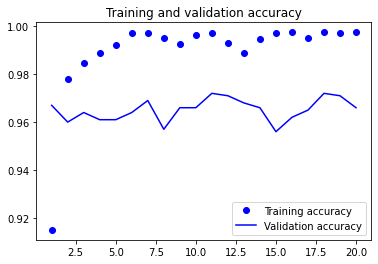

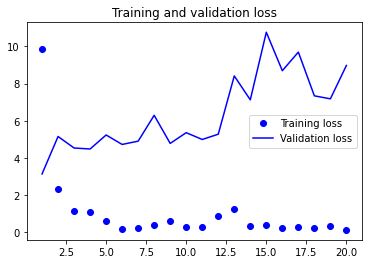

In [17]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [19]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [20]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [23]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 21s 260ms/step - loss: 9.2084 - accuracy: 0.8995 - val_loss: 4.9458 - val_accuracy: 0.9570
Epoch 2/50
63/63 [==============================] - 15s 241ms/step - loss: 4.9934 - accuracy: 0.9425 - val_loss: 2.9995 - val_accuracy: 0.9730
Epoch 3/50
63/63 [==============================] - 15s 238ms/step - loss: 5.2053 - accuracy: 0.9505 - val_loss: 3.9446 - val_accuracy: 0.9710
Epoch 4/50
63/63 [==============================] - 15s 243ms/step - loss: 2.8190 - accuracy: 0.9615 - val_loss: 3.2041 - val_accuracy: 0.9680
Epoch 5/50
63/63 [==============================] - 15s 232ms/step - loss: 3.3845 - accuracy: 0.9550 - val_loss: 3.3700 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - 15s 230ms/step - loss: 2.6489 - accuracy: 0.9615 - val_loss: 3.2101 - val_accuracy: 0.9670
Epoch 7/50
63/63 [==============================] - 15s 235ms/step - loss: 1.7183 - accuracy: 0.9765 - val_loss: 3.7514 - val_accuracy: 0.9670
Epoch 8/50

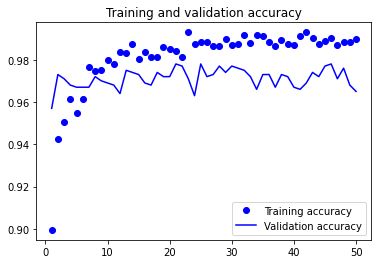

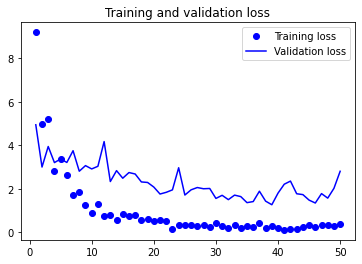

In [25]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 64ms/step - loss: 2.1329 - accuracy: 0.9590
Test accuracy: 0.959
